# Challenge Description
We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site). Your project is to: Predict conversion rate come up with recommendations for the product team and the marketing team to improve conversion rate

# Data
We have 1 table downloadable by clicking here.
5
The table is "conversion_data". It has information about signed-in users
during one session. Each row is a user session.
### Columns:
* **country**: user country based on the IP address
* **age**: user age. Self-reported at sign-in step
* **new_user**: whether the user created the account during this session or had already an account and simply came back to the site
* **source**: marketing channel source
* **Ads**: came to the site by clicking on an advertisement
* **Seo**: came to the site by clicking on search results
* **Direct**: came to the site by directly typing the URL on the browser
* **total_pages_visited**: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* **converted**: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions/ total sessions.

In [75]:
import csv
import numpy as np
import pandas as pd
from scipy.stats.mstats import mode
import statsmodels.api as sm
from numpy import genfromtxt
import sklearn
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline  



# Create a dataframe

In [76]:
df = pd.DataFrame()
df = pd.read_csv('conversion_data.csv')

In [77]:
df[:10]

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
5,US,31,0,Seo,1,0
6,China,27,1,Seo,4,0
7,US,23,0,Ads,4,0
8,UK,29,0,Direct,4,0
9,US,25,0,Ads,2,0


In [78]:
df.shape

(316200, 6)

In [79]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


# Preliminary Inspections

take a look at the converted vs not converted stats to see if I can get a better sense of the data

In [80]:
df.groupby('converted').mean()

,age,new_user,total_pages_visited
converted,,,
0,30.703961,0.698382,4.550281
1,26.546765,0.297941,14.553529


Total Pages Visited looks Promising

#### Q: Want to get the groupby 'converted' and then the mode of the country, age, and source


### Approach 1. Analyzing Conversion Rate by source  

In [81]:
number_by_source = df.groupby('source')['converted'].count()
print(number_by_source)


conversion_by_source = df.groupby('source')['converted'].sum()
print(conversion_by_source)

source
Ads        88740
Direct     72420
Seo       155040
Name: converted, dtype: int64
source
Ads       3060
Direct    2040
Seo       5100
Name: converted, dtype: int64


#### Q: How do i vertically append, and divide (separately and together) vstack doesn't work!!

## Modelling Conversion

Using Logistic Regression to predict conversion based on total_pages_visited 

##### Q: Is there a better way than to reshape using hardcode as below?

In [82]:
# using logistic regression using one column

logit = linear_model.LogisticRegression()
# print(df.shape)
# print(df['converted'].reshape(316200,1))
total_visited_raw = df['total_pages_visited'].reshape(316200,1)

##### Q: Didn't shuffle. Can't find the method to shuffle in pandas. Numpy shuffle doesn't work. numpy.random.shuffle Would love to find a easy way to shuffle

### Running k-folds validation with k = 5

In [83]:
twenty_p = len(total_visited_raw)//5

train = total_visited_raw[:-1* twenty_p]
validation =total_visited_raw[-1* twenty_p:]


##### Validation Score 

In [84]:
logit.fit(train, df['converted'][: -1 *twenty_p])
score = logit.score(validation, df['converted'][-1 *twenty_p:])

print("My logit based on just one variable, total_pages visited is {}".format(score))


My logit based on just one variable, total_pages visited is 0.9831435800126502


#### Plotting the findings

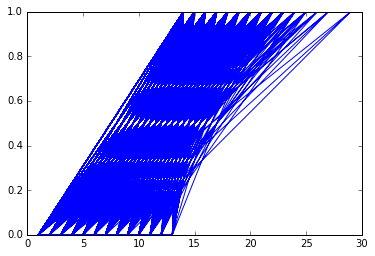

In [85]:
plt.figure()
plt.plot(validation, logit.predict(validation))
plt.show()

# Plotting ROC curve (Code modified from Monicah)

In [86]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(logit.predict(validation), validation) # pos_label=2)
roc_auc = auc(fpr,tpr)

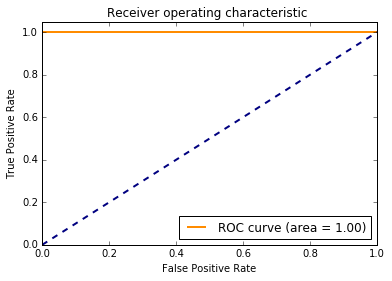

In [87]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') #plot the random
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

# Using stats model for logit (code modfied from Brian Goodness) 

similar to stat Stata in terms of validation

In [88]:
import statsmodels.api as sm

In [89]:
logit = sm.Logit( df['converted'][: -1 *twenty_p] , train)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.397150
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               252960
Model:                          Logit   Df Residuals:                   252959
Method:                           MLE   Df Model:                            0
Date:                Sun, 05 Feb 2017   Pseudo R-squ.:                  -1.780
Time:                        17:05:08   Log-Likelihood:            -1.0046e+05
converged:                       True   LL-Null:                       -36133.
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.4196      0.002   -266.390      0.000        -0.423    -0.417


# Misc Questions

#### How do I shape the data so that I get run a model? aka How do i slice the data? 
#### How do I take all columns except the "converted" column so that I can predict it
#### How do I take multiple columns?
